In [ ]:
# Phase 1: Setup & PySpark & pandas preprocessing in Jupyter Notebook

# Cell 0: Install required packages
!pip install pyspark pandas numpy matplotlib seaborn scipy scikit-learn==1.2.2 missingno category_encoders pysparkling h2o joblib

In [58]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA as skPCA

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


In [59]:
# Cell 2: Spark session setup
try:
    SparkContext.getOrCreate().stop()
except:
    pass
spark = (SparkSession.builder
         .master('local[*]')
         .appName('Phase1_Preprocessing')
         .config('spark.driver.bindAddress','127.0.0.1')
         .config('spark.driver.host','127.0.0.1')
         .getOrCreate())
print('Spark session started')

Spark session started


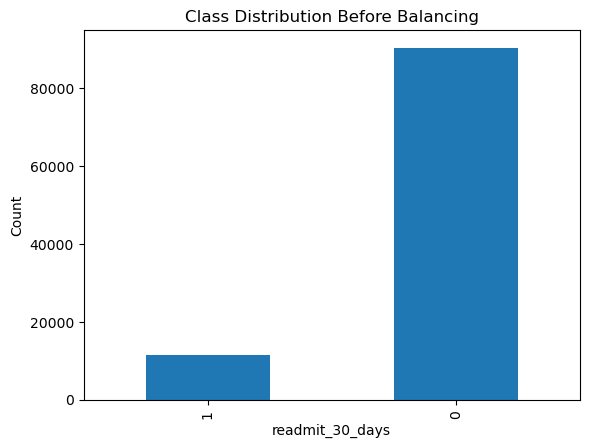

After oversampling: {1: 90556, 0: 90409}


In [62]:
# Cell 3: Load and balance via Spark oversampling
df = spark.read.csv(r'C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\diabetes_hospital_data.csv', header=True, inferSchema=True)
# Convert and visualize
counts = df.groupBy('readmit_30_days').count().toPandas().set_index('readmit_30_days')
counts.plot(kind='bar', legend=False)
plt.title('Class Distribution Before Balancing')
plt.ylabel('Count')
plt.show()

# Oversample minority class
major, minor = counts['count'].idxmax(), counts['count'].idxmin()
ratio = counts.loc[major,'count'] / counts.loc[minor,'count']
sdf = df.filter(col('readmit_30_days')==major).union(
    df.filter(col('readmit_30_days')==minor).sample(True, ratio, seed=42)
)
df = sdf.toPandas()
print('After oversampling:', df['readmit_30_days'].value_counts().to_dict())

In [63]:
# Cell 4: Data snapshot & stats
display(df.head())
display(df.describe(include='all').T)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,'30 years or younger',Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,'30 years or younger','Discharged to Home',Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,'30 years or younger','Discharged to Home',Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race,180965,6,Caucasian,136123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,180965,3,Female,97691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,180965,3,'Over 60 years',123764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_disposition_id,180965,2,'Discharged to Home',99177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_source_id,180965,3,Emergency,104347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,180965.0,NaN,NaN,NaN,4.554654,3.002175,1.0,2.0,4.0,6.0,14.0
medical_specialty,180965,6,Missing,90576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lab_procedures,180965.0,NaN,NaN,NaN,43.597254,19.515985,1.0,32.0,45.0,57.0,132.0
num_procedures,180965.0,NaN,NaN,NaN,1.311115,1.674878,0.0,0.0,1.0,2.0,6.0
num_medications,180965.0,NaN,NaN,NaN,16.385483,8.102772,1.0,11.0,15.0,20.0,81.0


In [64]:
# Cell 5: Drop extra targets
df.drop(columns=['readmitted','readmit_binary'], inplace=True)

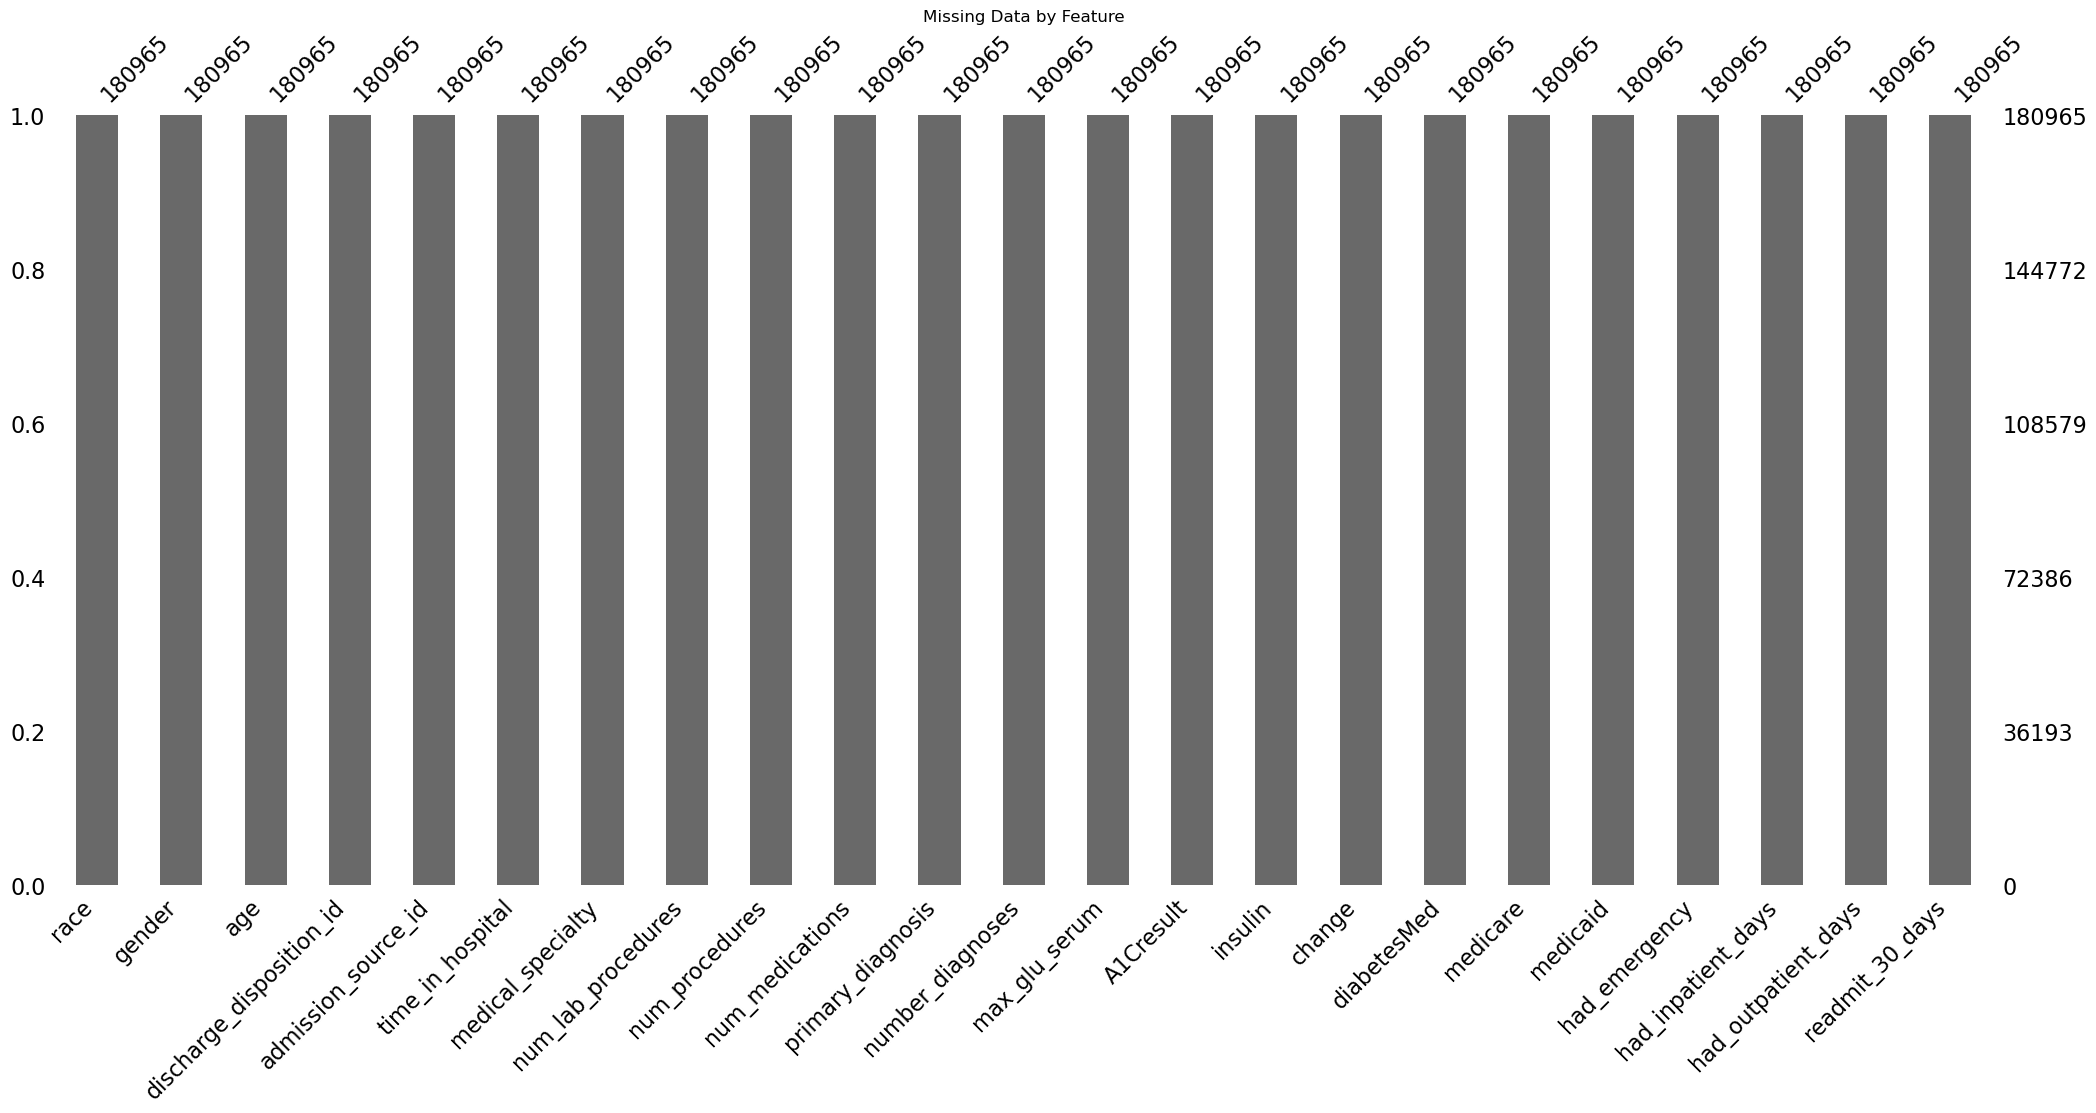

Missing values after imputation: 0 0


In [65]:
# Cell 6: Missing-value handling
msno.bar(df)
plt.title('Missing Data by Feature')
plt.show()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','bool']).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('Unknown')
print('Missing values after imputation:', df[num_cols].isna().sum().sum(), df[cat_cols].isna().sum().sum())

In [66]:
# Cell 7: Remove hospice/deceased cases
terms = ['Hospice','Expired','Death']
hosp_ids = [x for x in df['discharge_disposition_id'].unique() if any(t in str(x) for t in terms)]
df = df[~df['discharge_disposition_id'].isin(hosp_ids)]
print('After hospice removal:', df.shape)

After hospice removal: (180965, 23)


After outlier removal: (176418, 23)


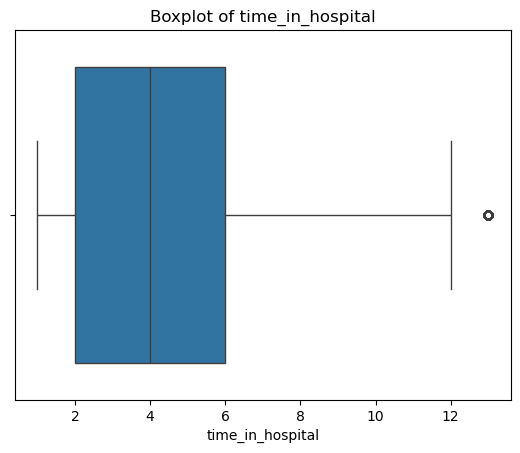

In [67]:
# Cell 8: Outlier removal (Z-score)
z = np.abs(stats.zscore(df[num_cols]))
df = df[(z<3).all(axis=1)]
print('After outlier removal:', df.shape)
# Boxplot of a sample numeric feature
sns.boxplot(x=df[num_cols[0]]); plt.title(f'Boxplot of {num_cols[0]}'); plt.show()

In [68]:
# Cell 9: ICD-9 grouping
icd_map = {'250':'Diabetes','401':'Hypertension','411':'Cardiovascular'}
df['diag_group'] = df['primary_diagnosis'].astype(str).str[:3].map(icd_map).fillna('Other')
print('Diagnosis groups:', df['diag_group'].value_counts())

Diagnosis groups: diag_group
Other    176418
Name: count, dtype: int64


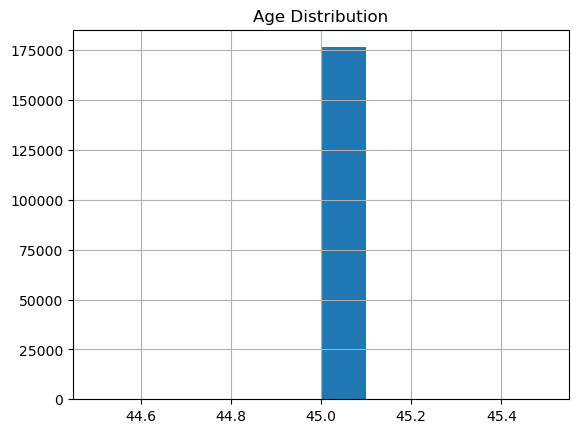

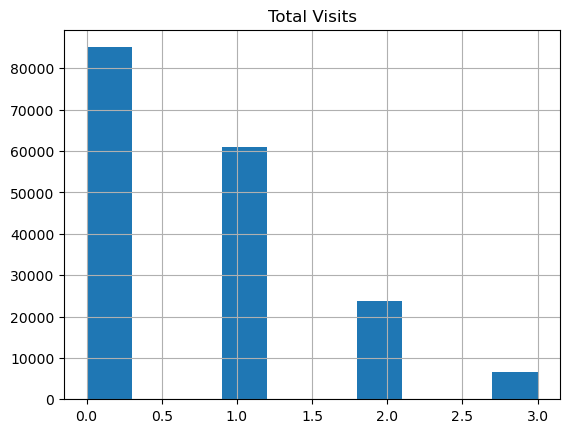

In [69]:
# Cell 10: Feature engineering
age_map = {'[0-30)':15,'[30-60)':45,'[60-90)':75}
df['age_encoded'] = df['age'].map(age_map).fillna(45)
df['total_visits'] = df[['had_emergency','had_inpatient_days','had_outpatient_days']].astype(int).sum(axis=1)
df['is_emergency'] = df['had_emergency'].astype(int)
# Histograms
df['age_encoded'].hist(bins=10); plt.title('Age Distribution'); plt.show()
df['total_visits'].hist(bins=10); plt.title('Total Visits'); plt.show()

In [70]:
# Cell 11: Categorical encoding
df = pd.get_dummies(df, columns=['gender','change','insulin','medical_specialty','diag_group'], drop_first=True)
print('After encoding, shape:', df.shape)
display(df.head(3))

After encoding, shape: (176418, 33)


,race,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,primary_diagnosis,number_diagnoses,...,gender_Unknown/Invalid,change_No,insulin_No,insulin_Steady,insulin_Up,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other
1,Caucasian,'30 years or younger','Discharged to Home',Emergency,3,59,0,18,Other,9,...,False,False,False,False,True,False,False,False,True,False
2,AfricanAmerican,'30 years or younger','Discharged to Home',Emergency,2,11,5,13,Other,6,...,False,True,True,False,False,False,False,False,True,False
3,Caucasian,'30-60 years','Discharged to Home',Emergency,2,44,1,16,Other,7,...,False,False,False,False,True,False,False,False,True,False


In [74]:
# Cell 12: Low-variance feature removal
selector = VarianceThreshold(0.01)
df_num = df.select_dtypes(include=[np.number])
support = selector.fit(df_num).get_support()
lowv = df_num.columns[~support]
df.drop(columns=lowv, inplace=True)
print('Dropped low-variance features:', list(lowv))

Dropped low-variance features: []


In [76]:
# Cell 13: Feature selection via Random Forest (with fallback)
from sklearn.feature_selection import SelectKBest, f_classif
# Determine k for feature selection
total_feats = df.drop('readmit_30_days', axis=1).shape[1]
k_feats = min(30, total_feats)
try:
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(df.drop('readmit_30_days', axis=1), df['readmit_30_days'])
    importances = pd.Series(rf.feature_importances_, index=df.drop('readmit_30_days', axis=1).columns)
    importances.sort_values().plot(kind='barh', figsize=(6,8))
    plt.title('Random Forest Feature Importances')
    plt.show()
    top_feats = importances.nlargest(k_feats).index.tolist()
    print(f'Selected top {k_feats} features via Random Forest')
except Exception as e:
    print('RandomForestClassifier failed, using SelectKBest ANOVA F-test:', e)
    selector_k = SelectKBest(f_classif, k=k_feats)
    selector_k.fit(df.drop('readmit_30_days', axis=1), df['readmit_30_days'])
    mask = selector_k.get_support()
    top_feats = df.drop('readmit_30_days', axis=1).columns[mask].tolist()
    print(f'Selected top {k_feats} features via ANOVA F-test')

# Subset dataset to selected features + target
df = df[top_feats + ['readmit_30_days']]

RandomForestClassifier failed, using SelectKBest ANOVA F-test: C variable sklearn.utils._random.DEFAULT_SEED has wrong signature (expected __pyx_t_7sklearn_5utils_7_random_UINT32_t, got __pyx_t_7sklearn_5utils_9_typedefs_uint32_t)
Selected top 23 features via ANOVA F-test


In [77]:
# Cell 14: Normalization (Z-normalization) (Z-normalization)
scaler = StandardScaler().fit(df[top_feats])
df[top_feats] = scaler.transform(df[top_feats])

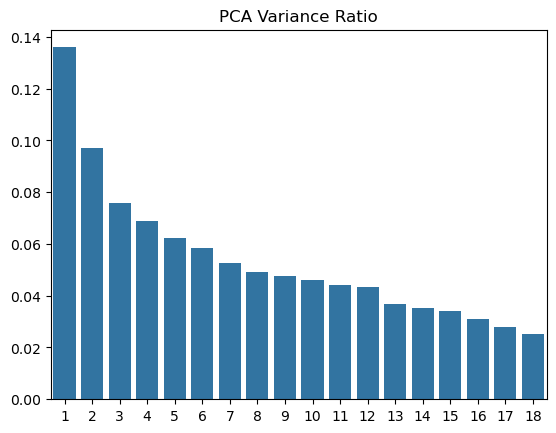

In [78]:
# Cell 15: PCA (optional)
pca = skPCA(n_components=0.95, svd_solver='full')
X_p = pca.fit_transform(df[top_feats])
pcs = X_p.shape[1]
sns.barplot(x=list(range(1,pcs+1)), y=pca.explained_variance_ratio_)
plt.title('PCA Variance Ratio')
plt.show()
# Create DataFrame with PCs and target
df_pca = pd.DataFrame(X_p, columns=[f'PC{i+1}' for i in range(pcs)])
df_pca['readmit_30_days'] = df['readmit_30_days'].values

In [80]:
# Cell 17: Save preprocessed data
os.makedirs('data', exist_ok=True)
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
train_df.to_csv('data/train_preprocessed.csv', index=False)
test_df.to_csv('data/test_preprocessed.csv', index=False)
print('Saved train/test CSVs')

Saved train/test CSVs


In [53]:
# Cell 17: Save preprocessed data to CSV
# Define output file paths
train_output = 'data/train_preprocessed.csv'
test_output = 'data/test_preprocessed.csv'

# Ensure output directory exists
output_dir = os.path.dirname(train_output)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# Save dataframes
train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)
train_df.to_csv(train_output, index=False)
test_df.to_csv(test_output, index=False)
print(f"Saved preprocessed files: {train_output}, {test_output}")

Saved preprocessed files: data/train_preprocessed.csv, data/test_preprocessed.csv


Raw data shape: (101766, 25)
Processed data shape: (176418, 19)


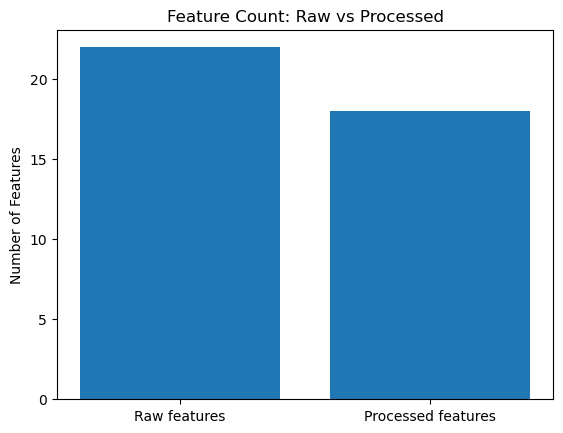

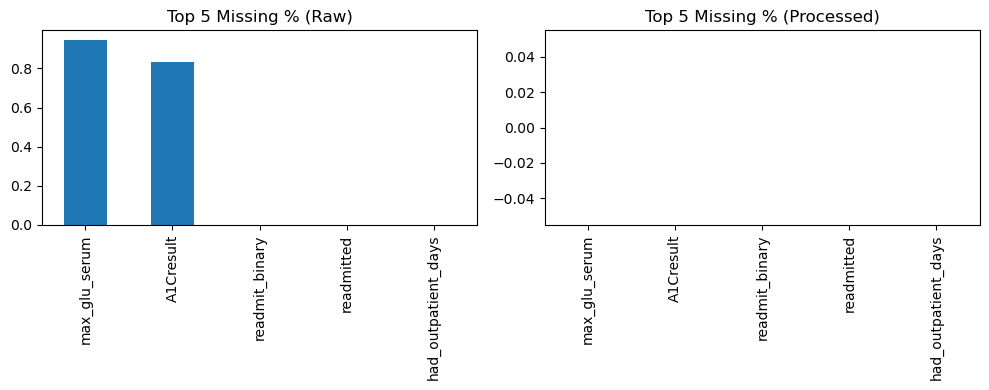

In [83]:
# Cell 18: Comparison Before vs After Preprocessing
# Reload original raw data
raw_df = pd.read_csv('C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\diabetes_hospital_data.csv')
# Compare shapes and missingness
print(f"Raw data shape: {raw_df.shape}")
print(f"Processed data shape: {df_pca.shape}")

# Plot number of features before/after
counts = {'Raw features': raw_df.shape[1]-3,  # exclude target cols
          'Processed features': df_pca.shape[1]-1}  # exclude target
plt.bar(counts.keys(), counts.values())
plt.title('Feature Count: Raw vs Processed')
plt.ylabel('Number of Features')
plt.show()

# Missing values before/after
def missing_percent(df_in):
    return df_in.isna().mean().sort_values(ascending=False)
raw_miss = missing_percent(raw_df)
proc_miss = missing_percent(df_pca)
# Align top5 features that still exist
top5 = raw_miss.head(5).index.tolist()
# Filter proc_miss to only those in top5; missing ones get 0
proc_vals = [proc_miss.get(f, 0) for f in top5]

fig, axes = plt.subplots(1,2, figsize=(10,4))
raw_miss[top5].plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 5 Missing % (Raw)')

pd.Series(proc_vals, index=top5).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 5 Missing % (Processed)')

plt.tight_layout()
plt.show()

In [84]:
# Cell 19: (Optional) Stop Spark session
# End of Phase 1. Spark session can be stopped here if you plan to start Phase 2 in a new session.
spark.stop()
print('Phase 1 Spark session stopped')


Phase 1 Spark session stopped
